## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные
В качестве входных данных Вы имеете 4 csv-файла:
* ***groups.csv*** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* ***groups_add.csv*** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* ***active_studs.csv*** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
* ***checks.csv*** - файл с информацией об оплатах пользователей в дни проведения эксперимента

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency
import pandahouse as ph

## EDA

In [2]:
group = pd.read_csv('~/ilina_ira/groups.csv', sep=';')
groups_add = pd.read_csv('~/ilina_ira/group_add.csv')
active_studs = pd.read_csv('~/ilina_ira/active_studs.csv')
checks = pd.read_csv('~/ilina_ira/checks.csv', sep=';')

In [3]:
def showing(data):
    print(data.head(3))
    print()
    print(data.info())
    print()
    print('Количество уникальных значений: ', data.nunique())
    print('Количество дубликатов: ', data.duplicated().sum())
    print('Количество пропусков: ', data.isnull().sum())

In [4]:
print('group')
print()
showing(group)
print()
print('groups_add')
print()
showing(groups_add)
print()
print('active_studs')
print()
showing(active_studs)
print()
print('checks')
print()
showing(checks)

group

     id grp
0  1489   B
1  1627   A
2  1768   B

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None

Количество уникальных значений:  id     74484
grp        2
dtype: int64
Количество дубликатов:  0
Количество пропусков:  id     0
grp    0
dtype: int64

groups_add

        id grp
0  5694584   B
1  5694830   B
2  5695057   B

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None

Количество уникальных значений:  id     92
grp     2
dtype: int64
Количество дубликатов:  0
Количество пропу

Все id уникальны, две группы - как и должно быть, нет повторяющихся значений и пропусков, и всего 39 уникальных платежа. Скорее всего на платформе есть определенные услуги с фиксированной ценой.   

Теперь нам нужно собрать все фреймы вместе. Сначала, объединив данные о принадлежности пользователя к группе, мы узнаем, сколько всего пользователей посетили платформу в дни проведения тестирования.

In [5]:
groups = pd.concat([group, groups_add]).rename(columns={'grp': 'group'})

In [6]:
print('groups')
print()
showing(groups)

groups

     id group
0  1489     B
1  1627     A
2  1768     B

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   group   74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB
None

Количество уникальных значений:  id       74576
group        2
dtype: int64
Количество дубликатов:  0
Количество пропусков:  id       0
group    0
dtype: int64


In [7]:
groups.group.value_counts()

B    59883
A    14693
Name: group, dtype: int64

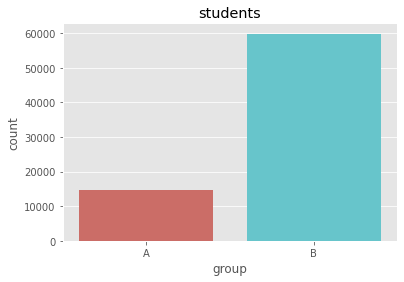

In [8]:
ax = sns.barplot(x='group', y='id', data=groups.
                 groupby('group', as_index=False)['id'].count(), palette='hls')
ax.set_title('students')
ax.set_ylabel('count');

Данные из обоих датафреймов без пропусков и дубликатов, а все пользователи уникальны. В контрольной группе (А) - **14693** пользователя, в целевой (B) - **59883**.  

Далее добавим информацию об активности пользователей. И через left merge добавим этот датафрейм к общему, чтобы сохранить все id из общей таблицы.

In [9]:
# добавим к этому датафрейму дополнительную колонку с 1, чтобы при объединении 
# заполнить пропуски 0 и в итоге получить колонку статуса с бинарными значениями,
# переименуем столбец для удобства
active_studs['active'] = 1
active_studs = active_studs.rename(columns={'student_id': 'id'})
all_data = groups.merge(active_studs, on='id', how='left').fillna(0)

То же самое проделаем с таблицей checks.

In [10]:
# После объединения у всех, кто совершил платеж будет статус - 1, у остальных будет статус - 0
checks['pay'] = 1
checks = checks.rename(columns={'student_id': 'id'})
all_data = all_data.merge(checks, on='id', how='left').fillna(0)

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      74576 non-null  int64  
 1   group   74576 non-null  object 
 2   active  74576 non-null  float64
 3   rev     74576 non-null  float64
 4   pay     74576 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.4+ MB


In [12]:
all_data.head()

,id,group,active,rev,pay
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


In [13]:
all_data.query('rev > 0').active.value_counts()

1.0    392
0.0    149
Name: active, dtype: int64

Если смотреть на распределение пользователей, совершивших оплату, можно обратить внимание, что часть пользователей, совершивших оплату в дни эксперимента, на платформу не заходила. Это как минимум странно, но такое возможно, например, при автопродлении подписки/истечении пробного периода.  

Так как нам нужно решить, стоит ли запускать новую механику на всех пользователей и проанализировать итоги эксперимента, нас интересуют только те пользователи, которые посещали платформу в дни эксперимента.  

Основной задечей любого бизнеса является увеличение дохода, поэтому мы тестируем новую механику оплаты. И использовать будем такие метрики, как:

* **ARPPU** (средний чек) - средняя выручка на платящего пользователя
* **CR** - конверсия в покупку  

Для других метрик данных недостаточно.

In [14]:
df = all_data.query('active == 1')

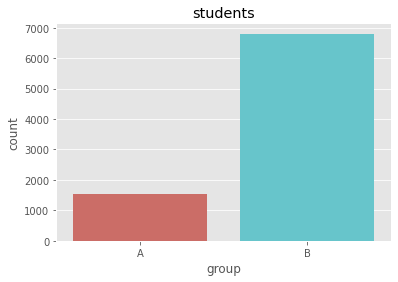

In [15]:
ax = sns.barplot(x='group', y='id', data=df.groupby('group', as_index=False)['id'].count(), palette='hls')
ax.set_title('students')
ax.set_ylabel('count');

Количество студентов в тестовой и контрольной группах сильно различается.

#### ARPPU

In [16]:
arppu = df.query('rev > 0') \
    .groupby('group', as_index=False) \
    .agg({'rev': 'mean'}) \
    .rename(columns={'rev': 'ARPPU'})
arppu

,group,ARPPU
0,A,933.589744
1,B,1257.878992


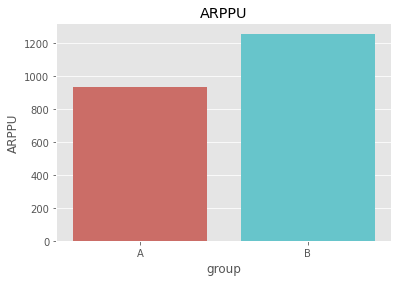

In [17]:
ax = sns.barplot(x='group', y='ARPPU', data=arppu, palette='hls')
ax.set_title('ARPPU');

#### CR

In [18]:
cr = df.groupby('group', as_index=False) \
    .agg({'id': 'count', 'pay': 'sum'}) \
    .rename(columns={'id': 'id_count', 'pay': 'pay_count'})

cr['CR'] = cr.pay_count / cr.id_count * 100
cr = cr[['group', 'CR']]
cr

,group,CR
0,A,5.071521
1,B,4.615611


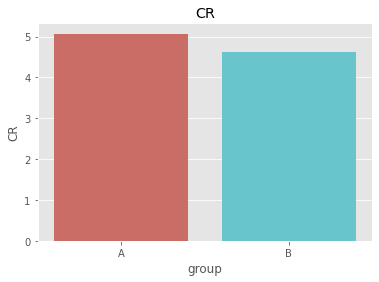

In [19]:
ax = sns.barplot(x='group', y='CR', data=cr, palette='hls')
ax.set_title('CR');

По графикам видим, что ARPPU в тестовой группе показали хороший результат - выше, чем в контрольной группе, но конверсия в тестовой группе ниже, чем в контрольной.  

Необходимо проверить статистическую значимость полученных результатов. Для этого посмотрим на распределение данных.

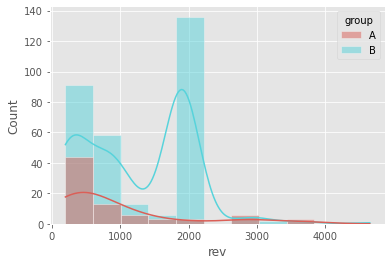

In [20]:
sns.histplot(x='rev', hue='group', data=df.query('rev > 0'), kde=True, palette='hls')

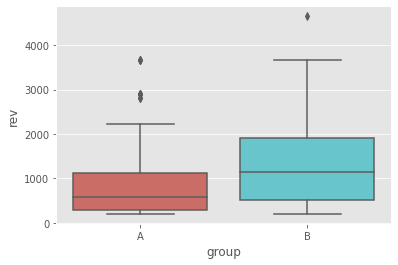

In [21]:
sns.boxplot(x='group', y='rev', data=df.query('rev > 0'), palette='hls');

In [22]:
pd.pivot_table(df.query('rev > 0'),
               values='id',
               index='rev',
               columns='group',
               aggfunc='count',
               fill_value=0).sort_values('B', ascending=False).head()

group,A,B
rev,,
1900.0000,0,93
290.0000,25,45
1900.0001,0,35
199.0000,5,27
840.0000,3,21


Видим явно ненормальное распределение. Оплаты на сумму 1900 и 1900,0001 производились только в тестовой группе. Возможно, так и проявляется наша новая механика оплаты. Но мы можем только предполагать, запустили ли для тестовой группы новый продукт, либо это какая-то акция/расширенная подписка. Остальные различия в распределении платежей несущественны и обусловлены разными размерами выборок. Так же имеются выбросы, но их мы удалять не будем.

## Проверга гипотез

Проверка гипотез о нормальности будет лишней (достаточно гистограммы); проверим однородности групповых дисперсий с помощью теста Левена:  
* Н0 : дисперсии в группах не различаются
* Н1 : дисперсии в группах различаются

In [23]:
group_A = df.query('rev > 0 & group == "A"').rev
group_B = df.query('rev > 0 & group == "B"').rev

In [24]:
stat, p = stats.levene(group_A, group_B)
print('Statistics=%.3f, p=%.3f' % (stat, p))

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0, дисперсии в группах различаются')
else:
    print('Не отклоняем H0, дисперсии в группах не различаются')

Statistics=3.076, p=0.080
Не отклоняем H0, дисперсии в группах не различаются


Проверим, есть ли различия в двух группах по ARPPU (средняя выручка на платящего пользователя), применив Т-тест, ведь он прост, быстр и у нас соблюдено требование о гомогенности дисперсий.
* Н0: нет различий по ARPPU
* Н1: есть различия по ARPPU

In [25]:
ttest_ind(group_A, group_B)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

Результат: p-value < 0.05 - принимаем альтернативную гипотезу, различия по ARPPU между группами A и B есть (эксперимент повлиял на ARPPU).  

Для проверги гипотезы о зависимости между группой и совершением оплаты применим Хи-квадрат, т.к. данные категориальные.
* H0: нет зависимости между группой и совершением оплаты
* H1: есть зависимость между группой и совершением оплаты

In [26]:
crosstab = pd.crosstab(df.query('active == 1')['group'], df.query('active == 1')['pay'])
crosstab

pay,0.0,1.0
group,,
A,1460,78
B,6489,314


In [27]:
stat, p, dof, expected = chi2_contingency(crosstab)
print(p)

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0, различия по CR между группами A и B есть (эксперимент повлиял на конверсию)')
else:
    print('Не отклоняем H0, различий по CR между группами A и B нет (эксперимент на конверсию не повлиял)')

0.48625240457231045
Не отклоняем H0, различий по CR между группами A и B нет (эксперимент на конверсию не повлиял)


**Вывод:** 

В результате расчетов получилось, что в случае с ARPPU мы можем отклонить нулевую гипотезу о незначительности отличий средних значений выборок при заданном уровне значимости p < 0,05. В случае с CR результаты противоположные. Новую механику оплаты на всех пользователей можно запускать, если целью бизнеса является увеличение среднего чека и ARPPU, а незначительное уменьшение конверсии НЕ является критичным.

## Задание 2. SQL. Очень усердные ученики.

### 2.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.  

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.   

*NB!* Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [28]:
connection_clickhouse = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database': 'default',
    'user': 'student',
    'password': 'dpo_python_2020'}

In [29]:
query_1 = '''
SELECT
    month,
    COUNT(st_id) as students
FROM
    (
    SELECT
        st_id,
        toStartOfMonth(timest) as month
    FROM peas
    WHERE
        month = '2020-03-01' AND correct = 1
    GROUP BY
        st_id,
        month
    HAVING COUNT(correct) >= 20
    )
GROUP BY month
'''

In [30]:
ph.read_clickhouse(query=query_1, connection=connection_clickhouse)

,month,students


Данные в базе только за один месяц.

In [31]:
query_2 = '''
SELECT
    month,
    COUNT(st_id) as students
FROM
    (
    SELECT
        st_id,
        toStartOfMonth(timest) as month
    FROM peas
    WHERE correct = 1
    GROUP BY
        st_id,
        month
    HAVING COUNT(correct)>=20
    )
GROUP BY month
  '''

In [32]:
ph.read_clickhouse(query=query_2, connection=connection_clickhouse)

,month,students
0,2021-10-01,136


Из этих данных получили, что 136 студентов являются усердными.

### 2.2 Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.  

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
* ARPU считается относительно всех пользователей, попавших в группы.  

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [33]:
metrics = '''
SELECT
    studs.test_grp AS group,
    round(SUM(money)/count(distinct(studs.st_id)),2) AS ARPU,
    round(sumIf(money, total_peas>10)/uniqIf(studs.st_id, total_peas>10),2) AS ARPAU,
    round(uniqIf(studs.st_id, money>0)/count(distinct(studs.st_id)) * 100, 2) AS CR,
    round(uniqIf(studs.st_id, money>0 and total_peas>10)/
        uniqIf(studs.st_id, total_peas>10) * 100, 2) AS CR_active,
    round(uniqIf(studs.st_id, money>0 and total_peas_math>=2 and subject='Math')/
        uniqIf(studs.st_id, total_peas_math>=2) * 100, 2) AS CR_math
FROM default.studs
LEFT JOIN 
    default.final_project_check
ON 
    final_project_check.st_id=studs.st_id
LEFT JOIN 
    (SELECT
        st_id,
        sum(correct) AS total_peas,
        sumIf(correct, subject='Math') AS total_peas_math
    FROM
        default.peas
    GROUP BY st_id) AS peas
ON
    studs.st_id=peas.st_id
GROUP BY group
'''

ph.read_clickhouse(query=metrics, connection=connection_clickhouse)

,group,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


## Задание 3. Python
### 3.1 Задача

#### Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [34]:
def get_info(group, groups_add, active_studs, checks):
    # загружаю данные
    group = pd.read_csv('~/ilina_ira/groups.csv', sep=';')
    groups_add = pd.read_csv('~/ilina_ira/group_add.csv')
    active_studs = pd.read_csv('~/ilina_ira/active_studs.csv')
    checks = pd.read_csv('~/ilina_ira/checks.csv', sep=';')
    # переименовываю заголовки, т.к. они могут отличаться и объединяем датасеты
    groups = pd.concat([group, groups_add]).rename(columns={'grp': 'group'})
    active_studs['active'] = 1
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    checks['pay'] = 1
    checks = checks.rename(columns={'student_id': 'id'})
    all_data = groups.merge(active_studs, on='id', how='left').fillna(0)\
                     .merge(checks, on='id', how='left').fillna(0)
    # отбираем активных пользователей
    df = all_data.query('active == 1')
    
    metrics = df.groupby('group', as_index=False) \
        .agg({'id': 'count', 'pay': ['sum', 'mean'], 'rev': ['sum', 'mean']})
    
    metrics.columns = ['group', 'students', 'checks', 'CR', 'rev', 'ARPPU']
    metrics['CR'] = metrics['CR'] * 100
    metrics['ARPPU'] = metrics['rev'] / metrics['checks']
    metrics['ARPU'] = metrics['rev'] / metrics['students']
    
    return metrics[['group', 'CR', 'ARPU', 'ARPPU']]

In [35]:
all_metrics = get_info(group, groups_add, active_studs, checks)
all_metrics

,group,CR,ARPU,ARPPU
0,A,5.071521,47.347204,933.589744
1,B,4.615611,58.058798,1257.878992


#### Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [36]:
def plotting(df):
    f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
    
    sns.barplot(x=all_metrics.group, y=all_metrics.ARPPU, palette="hls", ax=ax3)   
    ax3.set_title('ARPPU')
    ax3.set_ylabel('')
    ax3.set_xlabel('group')
    
    sns.barplot(x=all_metrics.group, y=all_metrics.ARPU, palette="hls", ax=ax2)   
    ax2.set_title('ARPU')
    ax2.set_ylabel('')
    ax2.set_xlabel('group')
    
    sns.barplot(x=all_metrics.group, y=all_metrics.CR, palette="hls", ax=ax1)
    ax1.set_title("CR")
    ax1.set_ylabel('')
    ax1.set_xlabel('group')

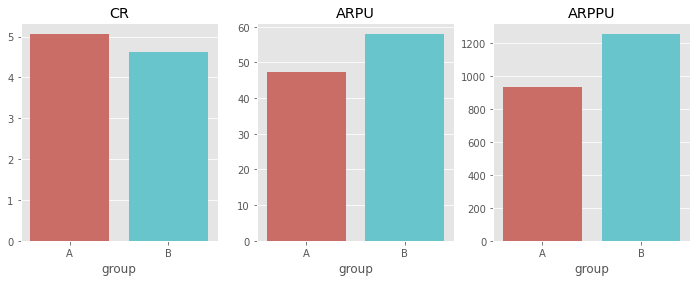

In [37]:
 plotting(all_metrics)